In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

import os
import json
import time
import math
from model import Model

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

%matplotlib inline
np.random.seed(1)

In [33]:
COL_NAMES = ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change']
filepath = "btc_apr_1_2012_to_apr_14_2019.csv"
df = pd.read_csv(filepath, thousands=',', names=COL_NAMES, index_col="Date", parse_dates=True, header=0)

assert(df.isnull().values.any()==False)

df.sort_index(ascending=True, inplace=True)

df = df[(df.index >= '2017-01-01')]
df['Volume'] = df['Volume'].apply(lambda x: float(x[:-1]))
df['Change'] = df['Change'].apply(lambda x: float(x[:-1]))
df.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-01,995.4,963.4,1001.6,956.1,41.15,3.33
2017-01-02,1017.0,995.4,1031.7,990.2,64.95,2.17
2017-01-03,1033.3,1017.0,1035.5,1006.5,54.79,1.60
2017-01-04,1135.4,1033.3,1148.5,1022.3,156.27,9.88
2017-01-05,989.3,1135.4,1150.6,874.5,240.01,-12.86


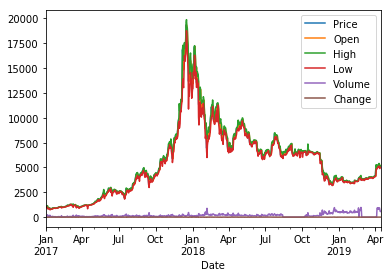

In [34]:
df.plot()

# Preprocess and Augment the data

In [5]:
import statsmodels.api as sm
import ta as ta
from statsmodels.tsa.statespace.varmax import VARMAX
from pykalman import KalmanFilter

data = df[['Price', 'Open', 'High', 'Low', 'Volume', 'Change']]

# Seasonal, Residual, Trend
s = sm.tsa.seasonal_decompose(np.flip(data[main_column].values), freq=60)
data['Trend'] = s.trend
data['Seasonal'] = s.seasonal
data['Residual'] = s.resid

# Technical Indicators
data['rsi'] = ta.momentum.rsi(data['Price'])
data['mfi'] = ta.momentum.money_flow_index(data['High'], data['Low'], data['Price'], data['Volume'])
data['adi'] = ta.volume.acc_dist_index(data['High'], data['Low'], data['Price'], data['Volume'])
data['vpt'] = ta.volume.volume_price_trend(data['Price'], data['Volume'])
data['atr'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Price'])
data['bb'] = ta.volatility.bollinger_hband(data['Price'])

# Simple Average
data['MovingAverage'] = data['Price'].rolling(window=30).mean()

# Varmax residuals
model = VARMAX(endog=np.asarray(data[['Price', 'Open', 'High', 'Low', 'Volume', "Change"]]))
model_fit = model.fit()
data['VAR_Price'] = model_fit.resid[:, 0]
data['VAR_Open'] = model_fit.resid[:, 1]
data['VAR_High'] = model_fit.resid[:, 2]
data['VAR_Low'] = model_fit.resid[:, 3]
data['VAR_Price'] = model_fit.resid[:, 4]
data['VAR_Change'] = model_fit.resid[:, 5]

# Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
measurements = data[['Price']].values
results = kf.em(measurements).smooth(measurements)
data['Kalman'] = results[0]

data = data.dropna()

# Scale data
scaler1 = MinMaxScaler(feature_range=(0, 1))
data[data.columns[list(data.min() >= 0)]] = scaler1.fit_transform(data[data.columns[list(data.min() >= 0)]])
data = pd.DataFrame(data)

scaler2 = MinMaxScaler(feature_range=(-1, 1))
data[data.columns[list(data.min() < 0)]] = scaler2.fit_transform(data[data.columns[list(data.min() < 0)]])

In [68]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
#     ax = fig.add_subplot(111)
    plt.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
#     ax = fig.add_subplot(111)
    plt.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [37]:
def prepare_data_many_to_one(seq, num_steps, test_ratio):
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
    y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
    train_size = int(len(X) * (1.0 - test_ratio))
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size, [0]], y[train_size:, [0]]

    return train_X, train_y, test_X, test_y

In [54]:
data_price = data['Price'].values.reshape(-1, 1)
test_ratio = 0.1
num_lstm_steps = 30

train_X, train_y, test_X, test_y = prepare_data_many_to_one(data_price, num_lstm_steps, test_ratio)
print('train_X.shape', train_X.shape)
print('train_y.shape', train_y.shape)
print('test_X.shape', test_X.shape)
print('test_y.shape', test_y.shape)

train_X.shape (669, 30, 1)
train_y.shape (669, 1)
test_X.shape (75, 30, 1)
test_y.shape (75, 1)


# Baseline: ARIMA

/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/cs230/lib/python3.7/site

MSE: 0.0006421882998606574


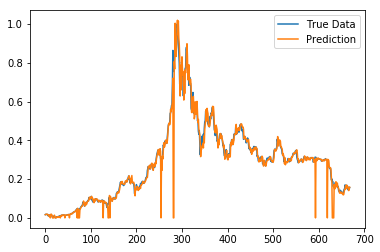

In [47]:
predictions = []
for x in train_X:
    try:
        model_arima = ARIMA(x, order=(5,1,0))
        model_fit = model_arima.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
    except:
        predictions.append(0)
    
valid = np.array(predictions) != 0
train_y_valid = np.array(predictions)[valid]
predictions_valid = np.array(train_y)[valid]
print("MSE:", mean_squared_error(train_y_valid, predictions_valid))
plot_results(predictions, train_y)

/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


MSE: 3.136016600955249e-05


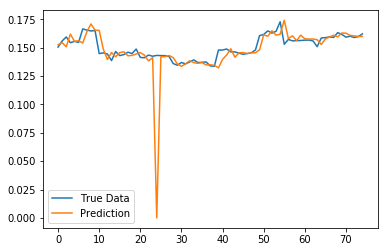

In [48]:
predictions = []
for x in test_X:
    try:
        model_arima = ARIMA(x, order=(5,1,0))
        model_fit = model_arima.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
    except:
        predictions.append(0)
    
valid_test = np.array(predictions) != 0
test_y_valid = np.array(predictions)[valid_test]
predictions_valid = np.array(test_y)[valid_test]
print("MSE:", mean_squared_error(test_y_valid, predictions_valid))
plot_results(predictions, test_y)

# Model 1: Single feature LSTM

In [55]:
configs = json.load(open('config_1feature.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

model_price = Model()
model_price.build_model(configs)

model_price.train(
    train_X,
    train_y,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size'],
    save_dir = configs['model']['save_dir']
)

[Model] Model Compiled
[Model] Training Started
[Model] 50 epochs, 32 batch size
Epoch 1/50
669/669 [==============================] - 4s 6ms/step - loss: 0.0200
Epoch 2/50
 64/669 [=>............................] - ETA: 1s - loss: 0.0059

/anaconda3/envs/cs230/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/anaconda3/envs/cs230/lib/python3.7/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


669/669 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 3/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0040
Epoch 4/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 5/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0039
Epoch 6/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0033
Epoch 7/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0029
Epoch 8/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 9/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 10/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 11/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 12/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 13/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 14/50
669/669 [==============

[Model] Predicting Point-by-Point...


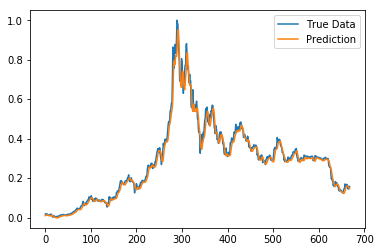

669
MSE: 0.0008584275747320467


In [58]:
predictions = model_price.predict_point_by_point(train_X)
plot_results(predictions, train_y)
print(len(predictions))
print("MSE:", mean_squared_error(train_y, predictions))

[Model] Predicting Point-by-Point...


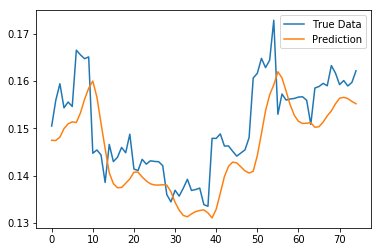

75
MSE: 6.081678608813576e-05


In [59]:
predictions = model_price.predict_point_by_point(test_X)
plot_results(predictions, test_y)
print(len(predictions))
print("MSE:", mean_squared_error(test_y, predictions))

In [61]:
data_raw = data.values
test_ratio = 0.1
num_lstm_steps = 30

train_X, train_y, test_X, test_y = prepare_data_many_to_one(data_raw, num_lstm_steps, test_ratio)
print('train_X.shape', train_X.shape)
print('train_y.shape', train_y.shape)
print('test_X.shape', test_X.shape)
print('test_y.shape', test_y.shape)

train_X.shape (669, 30, 22)
train_y.shape (669, 1)
test_X.shape (75, 30, 22)
test_y.shape (75, 1)


# Basline: VAR

669
MSE: 0.00013692089762806908


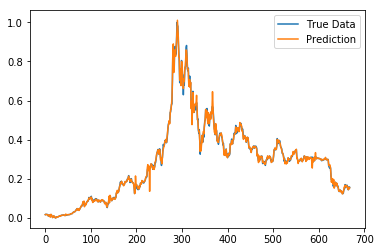

In [51]:
predictions = []
for x in train_X:
    var_model = VAR(endog=x)
    model_fit = var_model.fit()
    output = model_fit.forecast(model_fit.y, steps=1)
    yhat = output[0][0]
    predictions.append(yhat)
    
print(len(predictions))
print("MSE:", mean_squared_error(train_y, predictions))
plot_results(predictions, train_y)

75
MSE: 9.864411026509648e-06


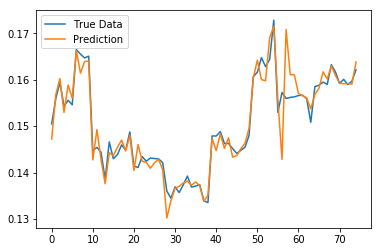

In [50]:
predictions = []
for x in test_X:
    var_model = VAR(endog=x)
    model_fit = var_model.fit()
    output = model_fit.forecast(model_fit.y, steps=1)
    yhat = output[0][0]
    predictions.append(yhat)
    
print(len(predictions))
print("MSE:", mean_squared_error(test_y, predictions))
plot_results(predictions, test_y)

In [63]:
configs = json.load(open('config_22feature.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None)
    
model_many_to_one = Model()
model_many_to_one.build_model(configs, opt=opt)

# in-memory training
model_many_to_one.train(
    train_X,
    train_y,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size'],
    save_dir = configs['model']['save_dir']
)

[Model] Model Compiled
[Model] Training Started
[Model] 200 epochs, 32 batch size
Epoch 1/200
669/669 [==============================] - 4s 6ms/step - loss: 0.3288
Epoch 2/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0070
Epoch 3/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 4/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 5/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0022
Epoch 6/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 7/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0019
Epoch 8/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0019
Epoch 9/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0022
Epoch 10/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0018
Epoch 11/200
669/669 [==============================] - 2s 3ms/step - loss: 0.0019
Epoch 12/200
6

669/669 [==============================] - 3s 4ms/step - loss: 5.1767e-04
Epoch 97/200
669/669 [==============================] - 2s 3ms/step - loss: 7.0681e-04
Epoch 98/200
669/669 [==============================] - 2s 3ms/step - loss: 6.1780e-04
Epoch 99/200
669/669 [==============================] - 2s 3ms/step - loss: 5.9037e-04
Epoch 100/200
669/669 [==============================] - 2s 3ms/step - loss: 7.5573e-04
Epoch 101/200
669/669 [==============================] - 2s 3ms/step - loss: 5.9355e-04
Epoch 102/200
669/669 [==============================] - 2s 3ms/step - loss: 6.8036e-04
Epoch 103/200
669/669 [==============================] - 2s 3ms/step - loss: 5.0858e-04
Epoch 104/200
669/669 [==============================] - 2s 3ms/step - loss: 5.3807e-04
Epoch 105/200
669/669 [==============================] - 2s 3ms/step - loss: 6.0341e-04
Epoch 106/200
669/669 [==============================] - 2s 3ms/step - loss: 5.8118e-04
Epoch 107/200
669/669 [==========================

KeyboardInterrupt: 

[Model] Predicting Point-by-Point...
MSE: 0.0005835868955700803


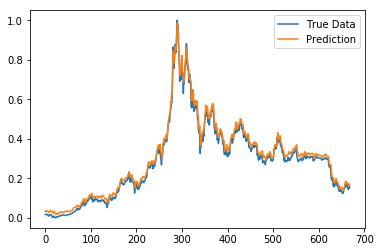

In [66]:
predictions = model_many_to_one.predict_point_by_point(train_X)
print("MSE:", mean_squared_error(train_y, predictions))
plot_results(predictions, train_y)

[Model] Predicting Point-by-Point...


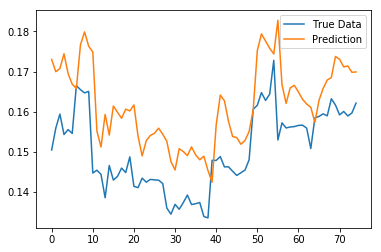

75
MSE: 0.0001612665353378756


In [65]:
predictions = model_many_to_one.predict_point_by_point(test_X)
plot_results(predictions, test_y)
print(len(predictions))
print("MSE:", mean_squared_error(test_y, predictions))

[Model] Predicting Sequences Multiple...


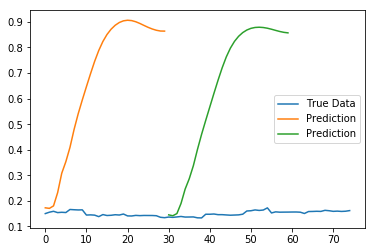

In [69]:
predictions = model_many_to_one.predict_sequences_multiple(test_X, configs['data']['sequence_length'], \
                                               configs['data']['sequence_length'])
plot_results_multiple(predictions, test_y, configs['data']['sequence_length'])

In [159]:
def prepare_data_many_to_many(seq, num_steps, test_ratio):
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps - 1)])
    y = np.array([seq[i+1:i + num_steps + 1] for i in range(len(seq) - num_steps - 1)])
    print(X.shape, y.shape)
    train_size = int(len(X) * (1.0 - test_ratio))
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size, :, [0]].squeeze(), y[train_size:, :, [0]].squeeze()

    return train_X, train_y, test_X, test_y

In [160]:
data_raw = data.values
test_ratio = 0.1
num_lstm_steps = 30

train_X_m2m, train_y_m2m, test_X_m2m, test_y_m2m = prepare_data_many_to_many(data_raw, num_lstm_steps, test_ratio)
print('train_X_m2m.shape', train_X_m2m.shape)
print('train_y_m2m.shape', train_y_m2m.shape)
print('test_X_m2m.shape', test_X_m2m.shape)
print('test_y_m2m.shape', test_y_m2m.shape)

(743, 30, 21) (743, 30, 21)
train_X_m2m.shape (668, 30, 21)
train_y_m2m.shape (668, 30)
test_X_m2m.shape (75, 30, 21)
test_y_m2m.shape (75, 30)


In [161]:
configs = json.load(open('config_21feature.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

model_m2m = Model()
model_m2m.build_model(configs)

# in-memory training
model_m2m.train(
    train_X_m2m,
    train_y_m2m,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size'],
    save_dir = configs['model']['save_dir']
)

[Model] Model Compiled
[Model] Training Started
[Model] 50 epochs, 32 batch size


ValueError: Error when checking target: expected dense_12 to have shape (1,) but got array with shape (30,)

[Model] Predicting Sequences Multiple...


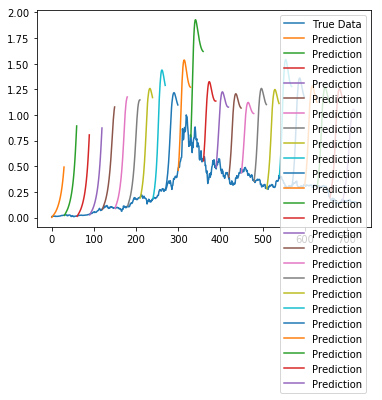

In [34]:
predictions = model_m2m.predict_sequences_multiple(train_X_m2m, configs['data']['sequence_length'], configs['data']['sequence_length'])
plot_results_multiple(predictions, train_y_m2m, configs['data']['sequence_length'])


[Model] Predicting Sequences Multiple...


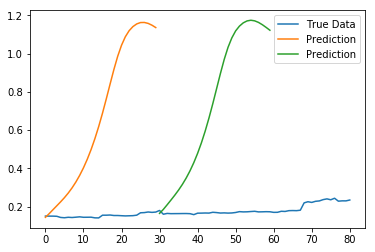

In [38]:
predictions = model_m2m.predict_sequences_multiple(test_X_m2m, configs['data']['sequence_length'], \
                                               configs['data']['sequence_length'])
plot_results_multiple(predictions, test_y_m2m, configs['data']['sequence_length'])

[Model] Predicting Sequences Full...


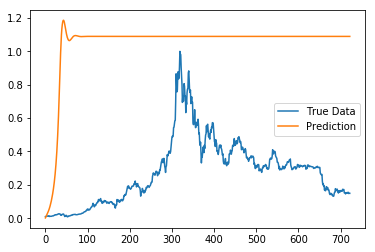

In [39]:
predictions = model_m2m.predict_sequence_full(train_X_m2m, configs['data']['sequence_length'])
plot_results(predictions, train_y_m2m)

[Model] Predicting Sequences Full...


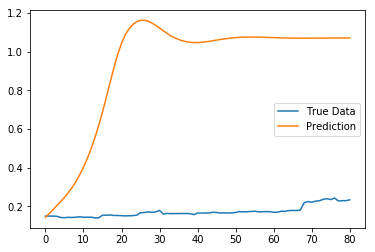

In [36]:
predictions = model_m2m.predict_sequence_full(test_X_m2m, configs['data']['sequence_length'])
plot_results(predictions, test_y_m2m)

[Model] Predicting Point-by-Point...


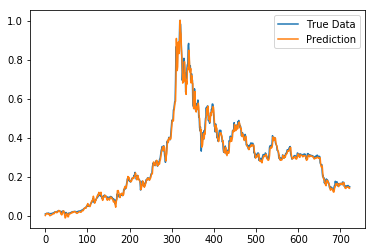

In [40]:
predictions = model_m2m.predict_point_by_point(train_X_m2m)
plot_results(predictions, train_y_m2m)

[Model] Predicting Point-by-Point...


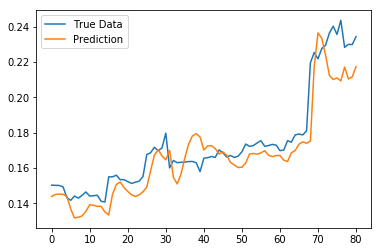

In [37]:
predictions = model_m2m.predict_point_by_point(test_X_m2m)
plot_results(predictions, test_y_m2m)